In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle

In [8]:
name='US-AR1'
#years=[2004,2006,2008,2012] #Var-Grass
years=[2010,2011,2012] #AR1-Grass
#years=[2006,2007,2008] #KUT-Grass
for year in years:
    print(name+'-'+str(year))
    df=pd.read_csv('data_csv_zip_clean/'+name+'_clean.csv.gz')
    df.time=pd.to_datetime(df.time)
    df=df.set_index(['time'])


    # fig,ax=plt.subplots(1,1)
    # plt.rcParams.update({'font.size': 15})
    # df.SWIN.plot(figsize=(20,10),ax=ax)

    period_start=str(year)+'-01-01'
    period_end=str(year+1)+'-01-01'
    # df_period=df
    df_period=df[(df.index>=period_start) & (df.index<period_end)]

    # fig,ax=plt.subplots(1,1)
    # plt.rcParams.update({'font.size': 15})
    # df_period[['SWIN','SWOUT']].plot(figsize=(20,10),ax=ax)

    df_period=df_period[df_period.SWIN>5]
    df_period=df_period[df_period.index.hour ==12]

    # fig,ax=plt.subplots(1,1)
    # plt.rcParams.update({'font.size': 15})
    alb_raw=df_period['SWOUT']/df_period['SWIN']
    alb=alb_raw[(alb_raw>0) & (alb_raw<1)]
    # alb.plot(figsize=(20,10),ax=ax)

    # fig,ax=plt.subplots(1,1,figsize=(20,10))
    # plt.rcParams.update({'font.size': 15})
    #alb_avg_day=alb.resample('1h', closed='left',label='right').mean()
    alb_avg_day=pd.DataFrame(alb,columns=['alb'])
    # plt.scatter(alb_avg_day.index,alb_avg_day)


    a=alb_avg_day.index.strftime('%j')
    alb_avg_day['DOY']=[int(b) for b in a]


    # fig,ax=plt.subplots(1,1,figsize=(20,10))
    # plt.rcParams.update({'font.size': 15})
    # plt.scatter(alb_avg_day.DOY,alb_avg_day.alb)
    # plt.ylim([0,.3])




    def func_parse_date(year, doy, hour, min):
            dt = pd.to_datetime(' '.join(
                [str(k) for k in [year, doy, hour, min]]),
                format='%Y %j %H %M')
            return dt


    copyfile("./runs/data/"+name+"_"+str(year)+"_data_60.txt", "runs/run/input/Kc_2012_data_60.txt")
    df_forcing=pd.read_csv('runs/run'+'/Input/'+'kc'+'_'+'2012'+'_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

    
    
    df_forcing.loc[:,'snow']=.8
    rol=df_forcing.Tair.rolling(5).mean()
    snowdetected=1
    for i in range(len(df_forcing)):

        if snowdetected==1:
            if rol.iloc[i]>=5:
                df_forcing.loc[df_forcing.iloc[i].name,'snow']=0
                snowdetected=0
            else:
                df_forcing.loc[df_forcing.iloc[i].name,'snow']=0.8
        else:
            df_forcing.loc[df_forcing.iloc[i].name,'snow']=0


        if (df_forcing.iloc[i].Tair<0) and (df_forcing.iloc[i].rain>0):
            df_forcing.loc[df_forcing.iloc[i].name,'snow']=0.8
            snowdetected=1        
    
    

    all_sites_info =  pd.read_csv('site_info.csv')
    site_info=all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame(
        {'Site': [name],
         'Latitude': [site_info['Latitude (degrees)']],
         'Longitude': [site_info['Longitude (degrees)']]})


    def modify_attr(df_state_init):
        df_state_init.loc[:,'emissionsmethod']=0
        df_state_init.loc[:,'sfr']=[0.0, #Paved
                                0.0, #Bldg
                                0.0, #EveTr
                                0.0, #DecTr
                                1.0, #Grass
                                0.0, #Bsoil
                                0.0] #Water
        df_state_init.loc[:,'lat']=df.Latitude.values[0].values[0]
        df_state_init.loc[:,'lng']=df.Longitude.values[0].values[0]

        #AR1
        df_state_init.loc[:,'laimin']=[0.75,0.5,.25]
        df_state_init.loc[:,'laimax']=[2.2,5,1]
        df_state_init.loc[:,'gddfull']=[450,450,450]
        df_state_init.loc[:,'sddfull']=[-370,-370,-370]
        df_state_init.loc[:,'basete']=[20,20,20]
        df_state_init.loc[:,'baset']=[5,5,5]
        df_state_init.albmin_grass=0.14
        df_state_init.albmax_grass=0.19
##------------------------------------------------------------
        #KUT
#         df_state_init.loc[:,'laimin']=[0.75,0.5,.1]
#         df_state_init.loc[:,'laimax']=[2.2,5,1.5]
#         df_state_init.loc[:,'gddfull']=[450,450,450]
#         df_state_init.loc[:,'sddfull']=[-370,-370,-370]
#         df_state_init.loc[:,'basete']=[13,13,13]
#         df_state_init.loc[:,'baset']=[5,5,5]
#         df_state_init.albmin_grass=0.15
#         df_state_init.albmax_grass=0.2
##------------------------------------------------------------
        df_state_init.albgrass_id=df_state_init.albmin_grass
        df_state_init.lai_id=df_state_init.loc[:,'laimin']


        return df_state_init

    path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    df_state_init=modify_attr(df_state_init)

    
    attrs=[
    df_state_init.albmin_grass,
    df_state_init.albmax_grass
    ]

    with open('albedo/'+name+'-attrs_albedo','wb') as f:
        pickle.dump(attrs, f)

    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)


    df_output_2=df_output.SUEWS.loc[grid]
    df_output_2=df_output_2[df_output_2.index.year>=year]

    alb_model=pd.DataFrame(df_output_2.AlbBulk)
    a=alb_model.index.strftime('%j')
    alb_model['DOY']=[int(b) for b in a]


    Tair=df_forcing_run.Tair.resample('1d', closed='left',label='right').mean()
    Tair=pd.DataFrame(Tair)
    a=Tair.index.strftime('%j')
    Tair['DOY']=[int(b) for b in a]

    lai=df_output_2.LAI
    lai=lai.resample('1d', closed='left',label='right').mean()
    lai=pd.DataFrame(lai)
    a=lai.index.strftime('%j')
    lai['DOY']=[int(b) for b in a]

    snow=df_forcing.snow
    snow.index=df_forcing.datetime
    snow=snow.resample('1D').mean()
    snow=pd.DataFrame(snow)
    a=snow.index.strftime('%j')
    snow['DOY']=[int(b) for b in a]

    rain=df_forcing_run.rain
    rain=rain.resample('1d', closed='left',label='right').sum()
    rain=pd.DataFrame(rain)
    a=rain.index.strftime('%j')
    rain['DOY']=[int(b) for b in a]   

    SMD=df_output_2.SMD
    SMD=SMD.resample('1d', closed='left',label='right').mean()
    SMD=pd.DataFrame(SMD)
    a=SMD.index.strftime('%j')
    SMD['DOY']=[int(b) for b in a] 
    
    out={'obs':{'x':alb_avg_day.DOY,'y':alb_avg_day.alb},
         'model':{'x':alb_model.DOY,'y':alb_model.AlbBulk},
         'Tair':{'x':Tair.DOY,'y':Tair.Tair},
         'lai':{'x':lai.DOY,'y':lai.LAI},
         'snow':{'x':snow.DOY,'y':snow.snow},
         'rain':{'x':rain.DOY,'y':rain.rain},
         'smd':{'x':SMD.DOY,'y':SMD.SMD},
        }
    with open('output/'+name+'-'+str(year),'wb') as f:
        pickle.dump(out, f)

US-AR1-2010
US-AR1-2011
US-AR1-2012


In [ ]:

name='US-AR1'
#years=[2004,2006,2008,2012] #Var-Grass
years=[2010,2011,2012] #AR1-Grass
#years=[2006,2007,2008] #KUT-Grass
colors= ['b','g','r','y','k','m']

plt.rcParams.update({'font.size': 15})
fig,axs=plt.subplots(4,1,figsize=(20,25))

counter=0
for year in years:
    
    color=colors[counter]
    
    with open('output/'+name+'-'+str(year),'rb') as f:
        out=pickle.load(f)
        
    ax=axs[0]
    ax.scatter(out['obs']['x'],out['obs']['y'],alpha=0.5,color=color,label='Obs-'+str(year))
    ax.scatter(out['model']['x'],out['model']['y'],color=color,marker='|',label='Model-'+str(year))
    
    ax=axs[1]
    ax.scatter(out['Tair']['x'],out['Tair']['y'],color=color,label='Tair-'+str(year))
    
    ax=axs[2]
    ax.scatter(out['lai']['x'],out['lai']['y'],color=color,label='LAI-'+str(year))
    
    
    counter=counter+1
    
ax=axs[0]
ax.set_ylim([0,.3])
ax.set_xlabel('DOY')
ax.set_ylabel('Albedo')
ax.legend(loc='best')
ax.set_title(name+'-Grass')


ax=axs[1]
ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe')
ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],label='BaseT')
ax.set_xlabel('DOY')
ax.set_ylabel('Tair (C)')
ax.legend(loc='best')


ax=axs[2]
ax.set_xlabel('DOY')
ax.set_ylabel('LAI')
ax.legend(loc='best')


ax=axs[3]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


world.plot(figsize=(15,15),ax=ax)
gdf.plot(ax=ax,color='r')

plt.savefig('figs/'+name+'-albedo.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

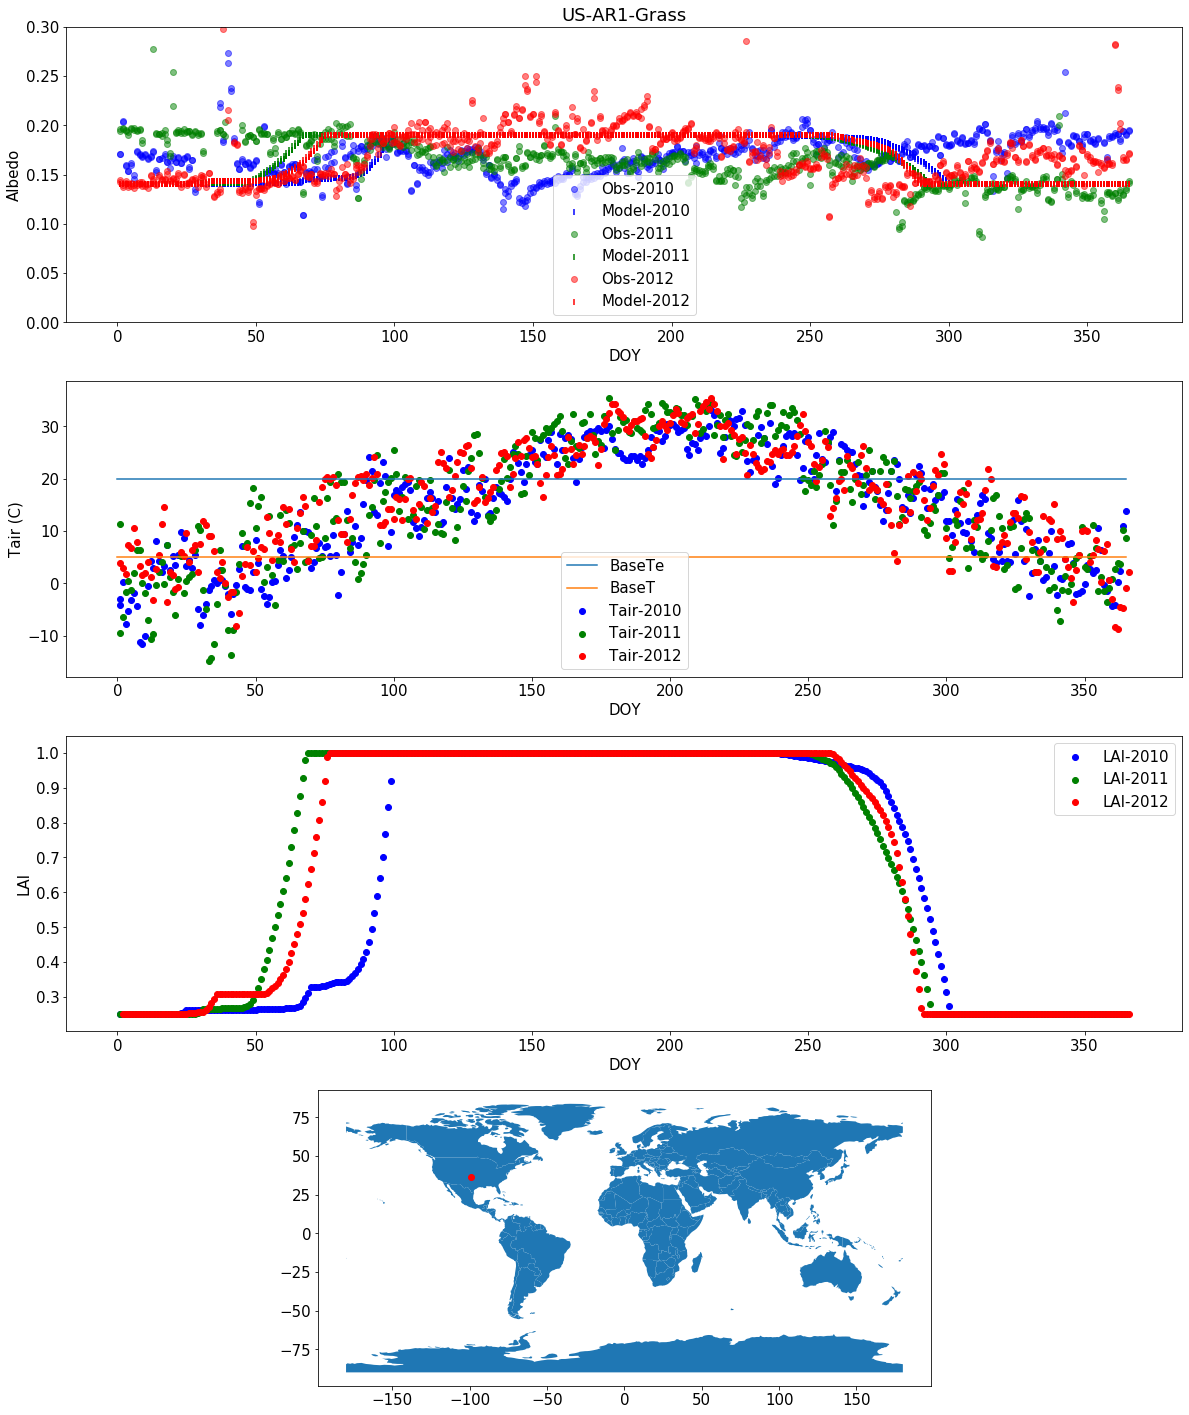

In [8]:
name='US-AR1'
#years=[2004,2006,2008,2012] #Var-Grass
years=[2010,2011,2012] #AR1-Grass
#years=[2006,2007,2008] #KUT-Grass
colors= ['b','g','r','y','k','m']

plt.rcParams.update({'font.size': 15})
fig,axs=plt.subplots(4,1,figsize=(20,25))

counter=0
for year in years:
    
    color=colors[counter]
    
    with open('output/'+name+'-'+str(year),'rb') as f:
        out=pickle.load(f)
        
    ax=axs[0]
    ax.scatter(out['obs']['x'],out['obs']['y'],alpha=0.5,color=color,label='Obs-'+str(year))
    ax.scatter(out['model']['x'],out['model']['y'],color=color,marker='|',label='Model-'+str(year))
    
    ax=axs[1]
    ax.scatter(out['Tair']['x'],out['Tair']['y'],color=color,label='Tair-'+str(year))
    
    ax=axs[2]
    ax.scatter(out['lai']['x'],out['lai']['y'],color=color,label='LAI-'+str(year))
    
    
    counter=counter+1
    
ax=axs[0]
ax.set_ylim([0,.3])
ax.set_xlabel('DOY')
ax.set_ylabel('Albedo')
ax.legend(loc='best')
ax.set_title(name+'-Grass')


ax=axs[1]
ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe')
ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],label='BaseT')
ax.set_xlabel('DOY')
ax.set_ylabel('Tair (C)')
ax.legend(loc='best')


ax=axs[2]
ax.set_xlabel('DOY')
ax.set_ylabel('LAI')
ax.legend(loc='best')


ax=axs[3]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


world.plot(figsize=(15,15),ax=ax)
gdf.plot(ax=ax,color='r')

plt.savefig('figs/'+name+'-albedo.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)